In [15]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time

In [16]:
import asyncio
import time
from bleak import BleakScanner, BleakClient

address = "00:35:FF:13:A3:76"
characteristic = "0000FFE1-0000-1000-8000-00805F9B34FB"


def parses_as_float(s):
    try :
        float(s)
        return True
    except :
        return False

log = bytearray()

def callback_raw_string(x,y):
    log.extend(y)


def parse_buffer(buffer):
    string_buffer = bytearray.decode(buffer)
    time_buffer = []
    voltage_buffer = []
    lines = string_buffer.splitlines()
    for l in lines:
        split = l.split(",")
        if len(split) == 2:
            (time, voltage) = split[0], split[1]
            if parses_as_float(time) and parses_as_float(voltage):
                t = float(time)
                time_buffer.append(t)
                voltage_buffer.append(float(voltage))
    return (time_buffer,voltage_buffer)

# def callback(x,y):
#     received_str = bytearray.decode(y)
#     lines = received_str.splitlines()
#     for l in lines:
#         split = l.split(",")
#         if len(split) == 2:
#             (time, voltage) = split[0], split[1]
#             if parse_as_float(time) and parse_as_float(voltage):
                    
#             t = float(time) / 1000.0
#             time_buffer.append(t)
#             voltage_buffer.append(float(voltage))
#     print(lines)
#     print(len(time_buffer))
    # numbers = list(map(lambda x: float(x), filter(lambda x: parses_as_float(x),lines)))

    # log.extend(numbers)
    # print(numbers,len(log))

async def main(address):
    async with BleakClient(address) as client:
        print(client.is_connected())
        # await client.pair()
        await client.get_services()
        print("Services:")
        for (k,s) in client.services.services.items():
            print(s)
        print("Characteristics:")
        for (k,s) in client.services.characteristics.items():
            print(s)
        start_time = time.time()
        execution_time = 0
        while execution_time < 30.0:
            await client.start_notify(characteristic,callback_raw_string)
            execution_time = (time.time() - start_time)
        (time_buffer,voltage_buffer) = parse_buffer(log)
        return (np.array(time_buffer),np.array(voltage_buffer))
        # client.unpair()
        # print("Model Number: {0}".format("".join(map(chr, model_number))))


(time_buffer,voltage_buffer) = await main(address)

/tmp/ipykernel_8453/2506619966.py:58: FutureWarning: is_connected has been changed to a property. Calling it as an async method will be removed in a future version
  print(client.is_connected())
/tmp/ipykernel_8453/2506619966.py:60: FutureWarning: This method will be removed future version, use the services property instead.
  await client.get_services()


<Future finished result=True>
Services:
0000ffe0-0000-1000-8000-00805f9b34fb (Handle: 16): Vendor specific
00001801-0000-1000-8000-00805f9b34fb (Handle: 12): Generic Attribute Profile
Characteristics:
0000ffe1-0000-1000-8000-00805f9b34fb (Handle: 17): Vendor specific
00002a05-0000-1000-8000-00805f9b34fb (Handle: 13): Service Changed


In [17]:
time_buffer,voltage_buffer, len(time_buffer),len(voltage_buffer)

(array([ 1.31,  1.36,  1.38, ..., 27.06, 27.08, 27.1 ]),
 array([2.42, 2.31, 2.31, ..., 2.36, 2.37, 2.39]),
 1079,
 1079)

In [18]:
N_samples = min(len(time_buffer),len(voltage_buffer))-1
time_buffer = time_buffer[:N_samples]
voltage_buffer = voltage_buffer[:N_samples]

In [19]:
# ser = serial.Serial(
#     # Serial Port to read the data from
#     port='/dev/ttyACM0',
#     baudrate=9600,
#     parity=serial.PARITY_NONE,
#     stopbits=serial.STOPBITS_TWO,
#     bytesize=serial.EIGHTBITS,
#     timeout=None
# )

In [20]:
def sample_buffer(n):
    time_buffer = []
    voltage_buffer = []
#     first = True
#     offset = 0.0
    while len(time_buffer) < n:
        line = ser.readline()
        if line:
            # Converting Byte Strings into unicode strings
            string = line.decode()
#             print(string)
            filter_string = '\n\r'
            string = "".join(filter(lambda c: c not in filter_string, string))
            split = string.split(",")
            if len(split) == 2:
                (time,voltage) = split[0],split[1]
                t = float(time)/1000.0
#                 if first:
#                     offset = t
#                     first = False
                # Converting Unicode String into integer
                time_buffer.append(t)
#                 time_buffer.append(t-offset)
        
                voltage_buffer.append(float(voltage))
    return (np.array(time_buffer), np.array(voltage_buffer))

In [21]:
N = N_samples-2
# line = ser.readline()
# ser.reset_input_buffer()
# ser.flush()
# startTime = time.time()
(time_samples, buffer) = (time_buffer,voltage_buffer)

# executionTime = (time.time() - startTime)
# ser.reset_input_buffer()
# ser.flush()
first_time = time_samples[1]
time_samples = time_samples[2:]-first_time
buffer = buffer[2:]
time_samples, buffer,len(time_samples),len(buffer)

(array([2.000e-02, 4.000e-02, 6.000e-02, ..., 2.567e+01, 2.570e+01,
        2.572e+01]),
 array([2.31, 2.33, 2.35, ..., 2.37, 2.36, 2.37]),
 1076,
 1076)

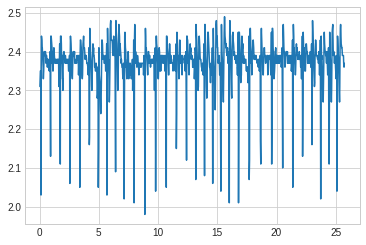

In [22]:
plt.plot(time_samples,buffer)

In [23]:
start_time = np.min(time_samples)
end_time = np.max(time_samples)
delta = (end_time-start_time)
start_time,end_time,delta,N

(0.019999999999999796, 25.72, 25.7, 1076)

In [24]:
oversampling_factor = 2
M = N*oversampling_factor
f_s = N/delta
times = np.linspace(0,delta,M)
resampled = np.interp(times,time_samples-start_time,buffer)
times,M,f_s

(array([0.00000000e+00, 1.19479312e-02, 2.38958624e-02, ...,
        2.56761041e+01, 2.56880521e+01, 2.57000000e+01]),
 2152,
 41.86770428015564)

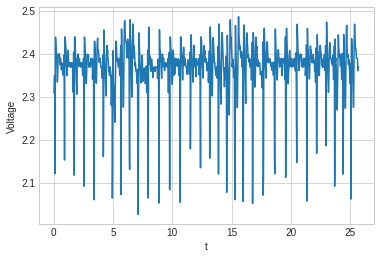

In [25]:
plt.style.use('seaborn-whitegrid')
plt.plot(times,resampled)
plt.xlabel('t')
plt.ylabel('Voltage')
plt.savefig('signal.png',transparent=False)

AAA
1076


(41.86770428015564, 1076)

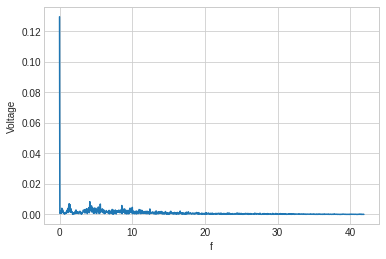

In [26]:
plt.style.use('seaborn-whitegrid')
fourier = np.fft.fft(resampled-2.5)[0:round(M/2)]
amplitudes = np.abs(fourier)/M
print("AAA")
print(len(amplitudes))
plt.plot(np.linspace(0,f_s,N),amplitudes)
plt.xlabel('f')
plt.ylabel('Voltage')
# plt.show()
plt.savefig('spectrum.png',transparent=False)
f_s,N

In [27]:
def bin_to_freq(fft_bin,f_s,N):
    return fft_bin*(f_s/N)
def freq_to_bin(f,f_s,N):
    return round(N*f/f_s)
cutoff_bin = freq_to_bin(200.0/60.0,f_s,N)
peak_nonzero_bin = np.argmax(amplitudes[1:cutoff_bin])
print("n: {}; n/2: {}".format(N,N/2))
print("Peak nonzero bin: {}; Run time: {}".format(peak_nonzero_bin,delta))

n: 1076; n/2: 538.0
Peak nonzero bin: 33; Run time: 25.7


In [29]:
peak_freq = bin_to_freq(peak_nonzero_bin,f_s,N)
bin_size = f_s/N
mid = peak_freq + bin_size/2.0
spread = bin_size/2.0

bpm_mid = mid*60.0
bpm_spread = bin_size*60.0
bpm = peak_freq*60.0
print("Peak frequency (Hz): {:.3g} +- {:.3g}; Peak frequency (BPM): {:.3g} +- {:.3g}".format(mid,spread,bpm_mid,bpm_spread))

Peak frequency (Hz): 1.3 +- 0.0195; Peak frequency (BPM): 78.2 +- 2.33


In [30]:
import tweepy
import json

In [31]:
with open("config.json") as file:
    config = json.load(file)

CONSUMER_KEY = config["CONSUMER_KEY"]
CONSUMER_SECRET= config["CONSUMER_SECRET"]
ACCESS_TOKEN= config["ACCESS_TOKEN"]
ACCESS_TOKEN_SECRET= config["ACCESS_TOKEN_SECRET"]
BEARER_TOKEN = config["BEARER_TOKEN"]

client = tweepy.Client(bearer_token=BEARER_TOKEN,
                       consumer_key=CONSUMER_KEY,
                       consumer_secret=CONSUMER_SECRET,
                       access_token=ACCESS_TOKEN,
                       access_token_secret=ACCESS_TOKEN_SECRET)

# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
  
# set access to user's access key and access secret 
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# calling the api 
api = tweepy.API(auth)
  
# the text to be tweeted
status = "Current BPM: {}".format(round(bpm))
  
# the path of the media to be uploaded
text = "Current BPM: {}".format(round(bpm))

filename1 = "signal.png"
media1 = api.media_upload(filename1)
filename2 = "spectrum.png"
media2 = api.media_upload(filename2)
print(media1)
print(media2)
# posting the tweet

# api.update_with_media(filename, status)

response = client.create_tweet(text=text,media_ids= [media1.media_id_string,media2.media_id_string])
print(response)


Media(_api=<tweepy.api.API object at 0x7f2a655edc60>, media_id=1588455419357396993, media_id_string='1588455419357396993', size=27452, expires_after_secs=86400, image={'image_type': 'image/png', 'w': 432, 'h': 288})
Media(_api=<tweepy.api.API object at 0x7f2a655edc60>, media_id=1588455421286703108, media_id_string='1588455421286703108', size=10425, expires_after_secs=86400, image={'image_type': 'image/png', 'w': 432, 'h': 288})
Response(data={'id': '1588455423081955331', 'text': 'Current BPM: 77 https://t.co/fcXJfUV9hy'}, includes={}, errors=[], meta={})


In [17]:

# import bluetooth

# print("Performing inquiry...")

# nearby_devices = bluetooth.discover_devices(duration=8, lookup_names=True,
#                                             flush_cache=True, device_id='00:35:FF:13:A3:76',lookup_class=False)

# print("Found {} devices".format(len(nearby_devices)))

# for addr, name in nearby_devices:
#     try:
#         print("   {} - {}".format(addr, name))
#     except UnicodeEncodeError:
#         print("   {} - {}".format(addr, name.encode("utf-8", "replace")))

In [18]:
# import socket

# baddr = '00:35:FF:13:A3:76'
# channel = 4
# s = socket.socket(socket.AF_BLUETOOTH, socket.SOCK_STREAM, 
# socket.BTPROTO_RFCOMM)
# s.connect((baddr,channel))
# s_sock = server_sock.accept()
# print ("Accepted connection from "+address)

# data = s_sock.recv(1024)
# print ("received [%s]" % data)

# s.listen(1)